# Leaf Analyser using Machine Learning Models and CNNs

In [155]:
import os

import kagglehub

from pathlib import Path

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, confusion_matrix

from IPython.display import Markdown, display

from matplotlib import pyplot as plt

from PIL import Image

import numpy as np

from skimage.color import rgb2gray
from skimage.filters import gabor

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


# Define Constants


In [2]:
IMAGE_SIZE = (128,128)

# Download the Dataset


In [3]:
# Folder where KaggleHub normally stores PlantVillage dataset
expected_path = (
        Path(os.path.expanduser("~"))
        / ".cache"
        / "kagglehub"
        / "datasets"
        / "emmarex"
        / "plantdisease"
)

# Check if the dataset has already been downloaded
if expected_path.exists():
    path = expected_path
    path = Path(path) / "versions" / "1" / "PlantVillage"
else:
    # If it doesn't exist, download
    print("Dataset not found. Downloading...\n")
    path = kagglehub.dataset_download("emmarex/plantdisease")
    path = expected_path
    path = Path(path) / "versions" / "1" / "PlantVillage"

# Dataset Summary


In [4]:
# Create lists to store the image filepaths and class labels
image_paths = []
labels = []

# Find all image files inside the dataset
# Consists of JPG, PNG, and JPEG
# PlantVillage is structured so that each class has its own folder
for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
    for img_path in path.rglob(ext):
        image_paths.append(str(img_path))
        labels.append(img_path.parent.name)  # folder name is the class label

# Create a dataframe containing the filepaths and labels
df = pd.DataFrame({
    "filepath": image_paths,
    "label": labels
})

# Define the target column
target_col = "label"

# Separate target and features
X = df.drop(columns=[target_col])
y = df[target_col]

# Display summary information to allow for quick dataset understanding
display(Markdown("#### PlantVillage Dataset Summary"))
print("Target column:\t\t\t", target_col)
print("DataFrame shape:\t\t", df.shape)
print("Total images:\t\t\t", len(df))
print("Number of classes:\t\t", y.nunique())
print("Class Names:\t\t\t", sorted(y.unique()))

#### PlantVillage Dataset Summary

Target column:			 label
DataFrame shape:		 (82552, 2)
Total images:			 82552
Number of classes:		 15
Class Names:			 ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# Image Preview


Image Preview and Matrix Size

Image 1 Size:  (256, 256, 3)
Image 2 Size:  (256, 256, 3)
Image 3 Size:  (256, 256, 3)


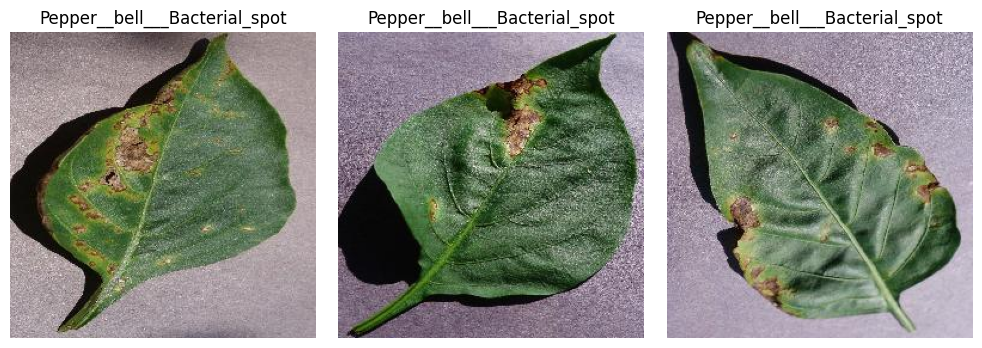

In [5]:
# Select the first 3 images from dataframe as a sample
sample_images = df["filepath"].iloc[:3].tolist()

# List to store the sample images that are being displayed for later comparison
original_samples = []

display(Markdown("Image Preview and Matrix Size"))
plt.figure(figsize=(10, 10))

for i, img_path in enumerate(sample_images):

    # Load the image
    img = Image.open(img_path)

    # Convert to array
    img_array = np.array(img)

    # Save original to list
    original_samples.append(img_array)

    # Display the image and print out the image size
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(df["label"].iloc[i])
    plt.axis("off")
    print(f"Image {i+1} Size:  {img_array.shape}")

plt.tight_layout()
plt.show()

# Image Preprocessing: Resizing
- Resizing images
- Validation (Previewing original vs resized images)
- Storing images in a list
- Loading the dataset and separating class names


In [6]:
# Function used to resize images
def convert_image_to_array(image_path):
    try:
        # Load the images and convert to RGB to keep consistent formatting
        img = Image.open(image_path).convert("RGB")

        # Resize the images to the specified image size
        img = img.resize(IMAGE_SIZE)

        # Convert into an array for processing
        return np.array(img, dtype=np.uint8)

    except Exception as e:
        # Print an error message if a file fails
        print(f"Error : {e}")
        return None

In [7]:
# Loads all images from the PlantVillage dataset and stores:
# - the processed image in a list
# - the folder name as a class label
# - the file path of that image
# The dataset is organised so that each folder represents a category
def load_images_from_directory(path):
    image_list = []     # for the resized images
    label_list = []     # to keep all labels in a list
    path_list = []      # to keep the original file path
    class_counts = {}   # dictionary to keep count of number of images

    print("[INFO] Loading images")

    # List all class folders
    class_folders = [
        f for f in os.listdir(path)
        if not f.startswith('.') and os.path.isdir(os.path.join(path, f))
    ]

    # Loop through each class directory
    for class_name in class_folders:
        class_path = os.path.join(path, class_name)

        # Collect all image files in that class folder
        images = [
            f for f in os.listdir(class_path)
            # Convert to lower so captures all image file endings
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        print(f"[INFO] Processing {class_name} ({len(images)} images)")

        class_counts[class_name] = len(images)

        # Process all images
        for img_name in images:
            img_path = os.path.join(class_path, img_name)

            try:
                img_array = convert_image_to_array(img_path)    # Call my resizing function and convert to array
                image_list.append(img_array)                    # Store the resized image in a list
                label_list.append(class_name)                   # Store the class label in a list
                path_list.append(img_path)                      # Store the path to a list
            except Exception as e:
                print(f"[WARNING] Could not load {img_path}: {e}")

    print("[INFO] Image loading completed.")
    return image_list, label_list, path_list, class_counts

In [8]:
# Call function to resize all images and get the class labels
image_list, label_list, path_list, class_counts = load_images_from_directory(path)

[INFO] Loading images
[INFO] Processing Pepper__bell___Bacterial_spot (997 images)
[INFO] Processing Pepper__bell___healthy (1478 images)
[INFO] Processing PlantVillage (0 images)
[INFO] Processing Potato___Early_blight (1000 images)
[INFO] Processing Potato___healthy (152 images)
[INFO] Processing Potato___Late_blight (1000 images)
[INFO] Processing Tomato_Bacterial_spot (2127 images)
[INFO] Processing Tomato_Early_blight (1000 images)
[INFO] Processing Tomato_healthy (1591 images)
[INFO] Processing Tomato_Late_blight (1909 images)
[INFO] Processing Tomato_Leaf_Mold (952 images)
[INFO] Processing Tomato_Septoria_leaf_spot (1771 images)
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite (1676 images)
[INFO] Processing Tomato__Target_Spot (1404 images)
[INFO] Processing Tomato__Tomato_mosaic_virus (373 images)
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus (3208 images)
[INFO] Image loading completed.


#### Image Preview

<Figure size 640x480 with 0 Axes>

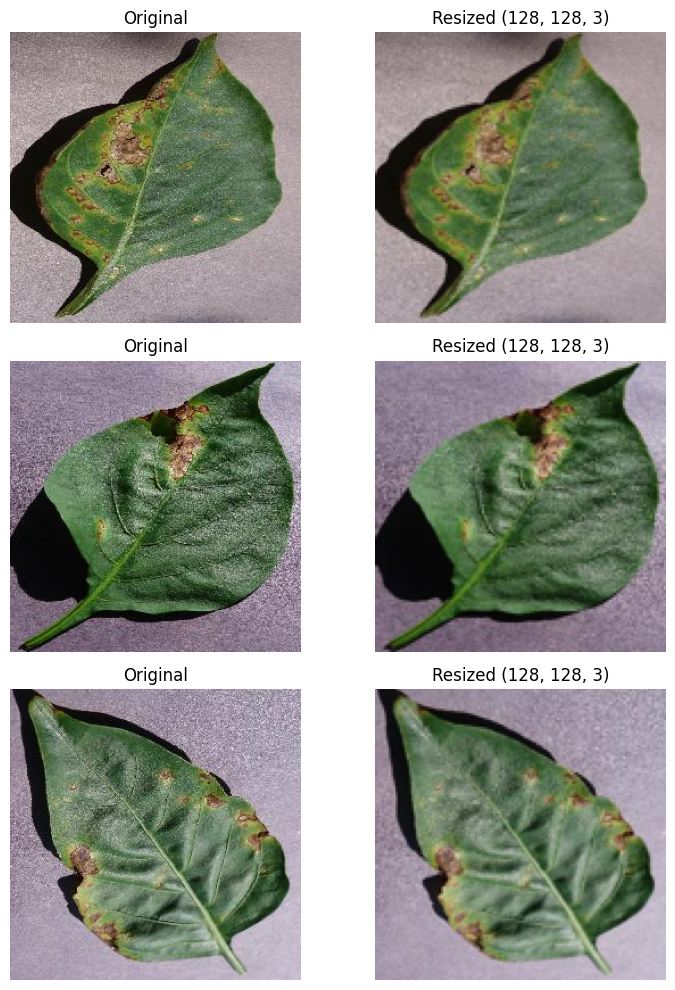

In [9]:
display(Markdown("#### Image Preview"))

plt.suptitle("Resized Image Samples")
plt.show()
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for idx in range(3):

    resized = image_list[idx]           # Load in the resized image
    orig = Image.open(path_list[idx])   # Load in the original for comparison

    # Original
    axes[idx, 0].imshow(orig)
    axes[idx, 0].set_title("Original")
    axes[idx, 0].axis("off")

    # Resized
    axes[idx, 1].imshow(resized.astype("uint8"))
    axes[idx, 1].set_title(f"Resized {resized.shape}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

# Split the Dataset
- Train (70%)
    - Used to fit the model and learns the patterns in the images
- Validation (15%)
    - Used to tune the model
- Test (15%)
    - Used at the end for final evaluation


In [55]:
X = np.array(image_list)   # shape: (N, H, W, 3)
y = np.array(label_list)   # class names

# Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# First split: Train (70%) and Temporary (30% for validation and testing)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y_encoded,
    test_size=0.30,
    stratify=y_encoded,
    random_state=42
)

# Second split: Validation (15%) and Testing (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

display(Markdown("#### Data Split Shape"))
print("Train X:\t\t", X_train.shape)
print("Validation X:\t", X_val.shape)
print("Test  X:\t\t", X_test.shape)

#### Data Split Shape

Train X:		 (14446, 128, 128, 3)
Validation X:	 (3096, 128, 128, 3)
Test  X:		 (3096, 128, 128, 3)


# View the Encoded Labels



In [56]:
# Store the encoded class names in a table
train_label_table = pd.DataFrame({
    "Encoded": sorted(set(y_train)),
    "Class Name": le.inverse_transform(sorted(set(y_train)))
})
display(Markdown("#### Encoded Class Names"))
display(train_label_table)

#### Encoded Class Names

,Encoded,Class Name
0,0,Pepper__bell___Bacterial_spot
1,1,Pepper__bell___healthy
2,2,Potato___Early_blight
3,3,Potato___Late_blight
4,4,Potato___healthy
5,5,Tomato_Bacterial_spot
6,6,Tomato_Early_blight
7,7,Tomato_Late_blight
8,8,Tomato_Leaf_Mold
9,9,Tomato_Septoria_leaf_spot


# Plant Healthy vs Diseased Breakdown



In [12]:
# List of plants inside folder
plants = ["Pepper", "Potato", "Tomato"]

display(Markdown("#### Healthy vs Diseased Breakdown per Plant"))

# Loop through each type of plant
for plant in plants:

    # Count all the total number of images which start with the plant name and contain the word healthy
    healthy = sum(
        count for cls, count in class_counts.items()
        if cls.startswith(plant) and "healthy" in cls.lower()
    )
    # Treat the rest as diseased
    diseased = sum(
        count for cls, count in class_counts.items()
        if cls.startswith(plant) and "healthy" not in cls.lower()
    )

    # Display the results
    display(Markdown(f"\t{plant}"))
    print("  Healthy:  ", healthy)
    print("  Diseased: ", diseased)

# Create a table with the results
df_summary = pd.DataFrame([
    {
        "Class": cls,
        "Health Status": "healthy" if "healthy" in cls.lower() else "diseased",
        "Count": count
    }
    for cls, count in class_counts.items()
])

display(df_summary)

#### Healthy vs Diseased Breakdown per Plant

	Pepper

  Healthy:   1478
  Diseased:  997


	Potato

  Healthy:   152
  Diseased:  2000


	Tomato

  Healthy:   1591
  Diseased:  14420


,Class,Health Status,Count
0,Pepper__bell___Bacterial_spot,diseased,997
1,Pepper__bell___healthy,healthy,1478
2,PlantVillage,diseased,0
3,Potato___Early_blight,diseased,1000
4,Potato___healthy,healthy,152
5,Potato___Late_blight,diseased,1000
6,Tomato_Bacterial_spot,diseased,2127
7,Tomato_Early_blight,diseased,1000
8,Tomato_healthy,healthy,1591
9,Tomato_Late_blight,diseased,1909


# Image Preprocessing: Augmentation


In [13]:
# Augmentation only applied to training data
train_aug = ImageDataGenerator(
    rescale = 1./255,           # normalise pixels as
    rotation_range=25,          # random rotations
    width_shift_range=0.1,      # horizontal translations
    height_shift_range=0.1,     # vertical translations
    shear_range=0.2,            # shearing effect
    zoom_range=0.2,             # random zoom in/out
    horizontal_flip=True,       # flips images horizontally
    fill_mode='nearest'         # fill empty pixels after rotations
)

# Validation and Test data won't be augmented
test_aug = ImageDataGenerator()

# Creating the training data generator
train_gen = train_aug.flow(
    X_train,        # X training
    y_train,        # y training
    batch_size=32,  # number of images per batch
    shuffle=True    # shuffle training data at each epoch
)

val_gen = test_aug.flow(
    X_val,
    y_val,
    batch_size=32,
    shuffle=False   # no shuffle
)

test_gen = test_aug.flow(
    X_test,
    y_test,
    batch_size=32,
    shuffle=False
)

#### Augmented Image Samples

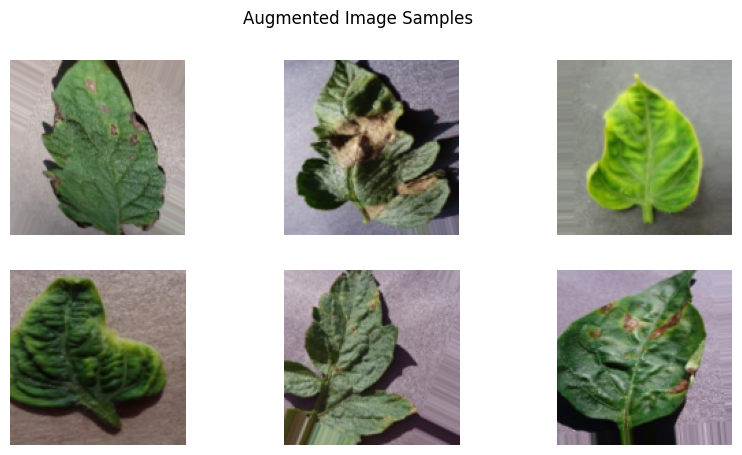

In [14]:
# Retrieve one batch of the augmented images from the training generator
augmented_images, _ = next(train_gen)

display(Markdown("#### Augmented Image Samples"))

# Show 6 images which were generated
# - they will have some kind of obscurity created by the augmentation generator
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis("off")

plt.suptitle("Augmented Image Samples")
plt.show()

# Image Preprocessing: Normalisation


In [15]:
# Normalise images
def normalise_images(X):
    # If already normalised, do not do it again
    if X.max() <= 1.0:
        return X.astype("float32")

    # Otherwise, normalise
    return (X / 255.0).astype("float32")

# Apply normalisation to each split
X_train = normalise_images(X_train)
X_val   = normalise_images(X_val)
X_test  = normalise_images(X_test)

display(Markdown("#### Min and Max Values of Normalisation:"))
# Ensure that each min and max pixel value is between 0 and 1
print("Train  min/max:", X_train.min(), X_train.max())
print("Val    min/max:", X_val.min(),   X_val.max())
print("Test   min/max:", X_test.min(),  X_test.max())

display(Markdown("#### Sample Pixel Block from X_train:"))
print(X_train[0][0:3, 0:3, :]) # Double check normalisation worked as expected

#### Min and Max Values of Normalisation:

Train  min/max: 0.0 1.0
Val    min/max: 0.0 1.0
Test   min/max: 0.0 1.0


#### Sample Pixel Block from X_train:

[[[0.63529414 0.61960787 0.6784314 ]
  [0.6039216  0.5882353  0.64705884]
  [0.6313726  0.6156863  0.6745098 ]]

 [[0.5882353  0.57254905 0.6313726 ]
  [0.6        0.58431375 0.6431373 ]
  [0.61960787 0.6039216  0.6627451 ]]

 [[0.6156863  0.6        0.65882355]
  [0.6117647  0.59607846 0.654902  ]
  [0.6117647  0.59607846 0.654902  ]]]


# Colour Histogram Extraction


In [16]:
# Number of bins for each colour channel
bins = 32

display(Markdown("#### Histogram List Shape:"))

# List to store histograms of training data
X_train_hist = []

# Loop through each training image
# Compute the histogram for each colour channel
# In the range 0 to 1 due to normalisation
for img_np in X_train:
    hist_r, _ = np.histogram(img_np[:, :, 0], bins=bins, range=(0, 1), density=False)
    hist_g, _ = np.histogram(img_np[:, :, 1], bins=bins, range=(0, 1), density=False)
    hist_b, _ = np.histogram(img_np[:, :, 2], bins=bins, range=(0, 1), density=False)

    # Combine all three histograms into a single feature vector
    features = np.concatenate([hist_r, hist_g, hist_b])

    # Store this feature vector for the current image
    X_train_hist.append(features)

# Convert list into a numpy array
X_train_hist = np.array(X_train_hist)

# Print out the shape for validation
print("X_train_hist:", X_train_hist.shape)

# Validation data
X_val_hist = []

for img_np in X_val:
    hist_r, _ = np.histogram(img_np[:, :, 0], bins=bins, range=(0, 1), density=False)
    hist_g, _ = np.histogram(img_np[:, :, 1], bins=bins, range=(0, 1), density=False)
    hist_b, _ = np.histogram(img_np[:, :, 2], bins=bins, range=(0, 1), density=False)

    features = np.concatenate([hist_r, hist_g, hist_b])
    X_val_hist.append(features)

X_val_hist = np.array(X_val_hist)
print("X_val_hist:", X_val_hist.shape)

# Testing data
X_test_hist = []

for img_np in X_test:
    hist_r, _ = np.histogram(img_np[:, :, 0], bins=bins, range=(0, 1), density=False)
    hist_g, _ = np.histogram(img_np[:, :, 1], bins=bins, range=(0, 1), density=False)
    hist_b, _ = np.histogram(img_np[:, :, 2], bins=bins, range=(0, 1), density=False)

    features = np.concatenate([hist_r, hist_g, hist_b])
    X_test_hist.append(features)

X_test_hist = np.array(X_test_hist)
print("X_test_hist:", X_test_hist.shape)

#### Histogram List Shape:

X_train_hist: (14446, 96)
X_val_hist: (3096, 96)
X_test_hist: (3096, 96)


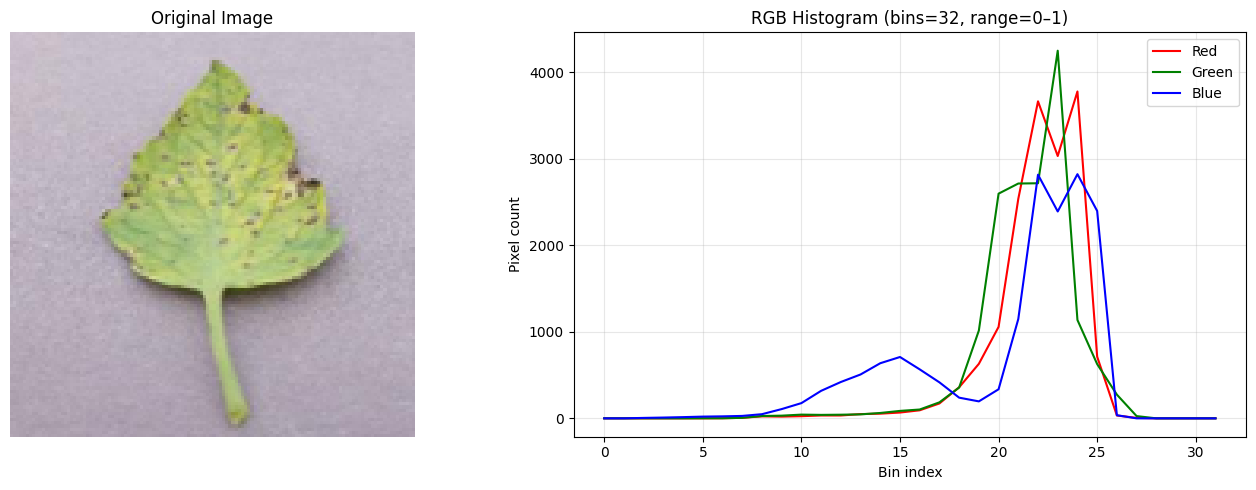

In [17]:
# Index of the example image
idx = 55

# Get the original image
img_np = X_train[idx]

# Get the histogram features for that image
hist = X_train_hist[idx]

hist_r = hist[:bins]         # Take the first 32 values
hist_g = hist[bins:2*bins]   # Take the second 32 values
hist_b = hist[2*bins:3*bins] # Take the third 32 values

# x-axis positions
x = np.arange(bins)

plt.figure(figsize=(14,5))

# Original image
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.axis("off")
plt.title("Original Image")

# RGB histogram
plt.subplot(1,2,2)
plt.plot(x, hist_r, 'r-', label="Red")
plt.plot(x, hist_g, 'g-', label="Green")
plt.plot(x, hist_b, 'b-', label="Blue")
plt.title("RGB Histogram (bins=32, range=0–1)")
plt.xlabel("Bin index")
plt.ylabel("Pixel count")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Gabor Filter
- Good to detect texture in images which would help identify unhealthy leaf images

In [29]:
# Gabor filter settings
thetas = [0, np.pi/2]           # Two orientations (0 and 90 degrees)
frequencies = [0.2, 0.4]        # Use of a low and high frequency

example_gabor = None   # Will store one example of a Gabor magnitude image

# Training set
X_train_gabor = []

# For each image inside the training set
for img_np in X_train:

    # Convert to grayscale for texture analysis as gabor is applied to single channel images only
    gray = rgb2gray(img_np)

    # This list will store the Gabor features for this image
    feats = []

    # Loop over all combinations of orientation and frequency
    for theta in thetas:
        for freq in frequencies:

            # Apply the Gabor filter
            # gabor() returns the real and frequency responses of the filter
            real, imag = gabor(gray, frequency=freq, theta=theta)

            # Compute the magnitude
            magnitude = np.sqrt(real**2 + imag**2)

            # Save one example, used for plotting later
            if example_gabor is None:
                example_gabor = magnitude
                example_original = img_np
                example_gray = gray

            # Use mean and std of magnitude as features
            feats.append(magnitude.mean())
            feats.append(magnitude.std())

    # Store the feature vector for this image
    X_train_gabor.append(feats)

# Convert list of feature vectors into a numpy array
X_train_gabor = np.array(X_train_gabor)

# Display the shape for validation
print("X_train_gabor shape:", X_train_gabor.shape)


# Validation data
# Repeat the same process
X_val_gabor = []

for img_np in X_val:
    gray = rgb2gray(img_np)
    feats = []

    for theta in thetas:
        for freq in frequencies:
            real, imag = gabor(gray, frequency=freq, theta=theta)
            magnitude = np.sqrt(real**2 + imag**2)
            feats.append(magnitude.mean())
            feats.append(magnitude.std())

    X_val_gabor.append(feats)

X_val_gabor = np.array(X_val_gabor)
print("X_val_gabor shape:", X_val_gabor.shape)


# Testing data
# Repeat the same process
X_test_gabor = []

for img_np in X_test:
    gray = rgb2gray(img_np)
    feats = []

    for theta in thetas:
        for freq in frequencies:
            real, imag = gabor(gray, frequency=freq, theta=theta)
            magnitude = np.sqrt(real**2 + imag**2)
            feats.append(magnitude.mean())
            feats.append(magnitude.std())

    X_test_gabor.append(feats)

X_test_gabor = np.array(X_test_gabor)
print("X_test_gabor shape:", X_test_gabor.shape)

X_train_gabor shape: (14446, 8)
X_val_gabor shape: (3096, 8)
X_test_gabor shape: (3096, 8)


# Gabor Filter Analysis


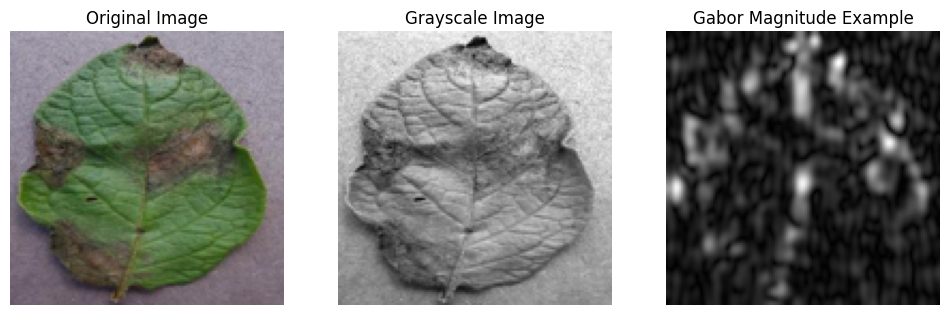

In [31]:
# Visualise the Gabor filter output
plt.figure(figsize=(12,4))

# Show the original image
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(example_original)
plt.axis("off")

# Show the greyscale image used as input to the Gabor filter
plt.subplot(1,3,2)
plt.title("Grayscale Image")
plt.imshow(example_gray, cmap="gray")
plt.axis("off")

# Show the Gabor magnitude response to show texture captured by the filter
plt.subplot(1,3,3)
plt.title("Gabor Magnitude Example")
plt.imshow(example_gabor, cmap="gray")
plt.axis("off")

plt.show()

# Merging Colour Histogram and Gabor Texture Features

In [37]:
# Combine the RGB histogram with the Gabor features
X_train_classical = np.concatenate([X_train_hist, X_train_gabor], axis=1)
X_val_classical   = np.concatenate([X_val_hist,  X_val_gabor],  axis=1)
X_test_classical  = np.concatenate([X_test_hist, X_test_gabor], axis=1)

# For validation show the shape
print(f"X_train_classical size:\t {X_train_classical.shape}")
print(f"X_val_classical size:\t {X_val_classical.shape}")
print(f"X_test_classical size:\t {X_test_classical.shape}")

X_train_classical size:	 (14446, 104)
X_val_classical size:	 (3096, 104)
X_test_classical size:	 (3096, 104)


# Feature Scaling for Classical Machine Learning Models

In [38]:
# This ensures all features contribute equally during training
scaler = StandardScaler()

# Fit scaler on data
X_train_scaled = scaler.fit_transform(X_train_classical)
X_val_scaled   = scaler.transform(X_val_classical)
X_test_scaled  = scaler.transform(X_test_classical)

# Training Classical Machine Learning Models
- Random Forest
- SVM (Support Vector Machine)
- k-NN (K-Nearest Neighbour)

In [146]:
# Define the models that will be used
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel="linear", probability=True, random_state=42),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

classic_models_results = {}
probabilities = {}

display(Markdown(f"Accuracy Results"))

for name, model in models.items():

    # Train on scaled data
    model.fit(X_train_scaled, y_train)

    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)

    # Probability needed for ROC-AUC score
    y_val_proba = model.predict_proba(X_val_scaled)

    # Compute evaluation metrics
    val_acc = accuracy_score(y_val, y_val_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_val,
        y_val_pred,
        average="macro"    # treat all classes equally
    )

    # Predict on test set
    y_test_pred  = model.predict(X_test_scaled)

    # Probability needed for ROC-AUC score
    y_test_proba = model.predict_proba(X_test_scaled)
    probabilities[name] = y_test_proba

    # Test metrics
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test,
        y_test_pred,
        average="macro",
        zero_division=0
    )

    # Compute the ROC-AUC score
    roc_auc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovr",
        average="macro"
    )

    # Store results for comparison later
    classic_models_results[name] = {
        "accuracy": test_acc,
        "precision": test_prec,
        "recall": test_rec,
        "f1": test_f1,
        "roc_auc": roc_auc
    }
    # Display accuracy percentage
    print(f"{name} Accuracy:\t\t\t\t {test_acc * 100:.2f}%")
    print(f"{name} ROC-AUC:\t\t\t\t {roc_auc:.4f}\n")

# Convert into a table to view results nicely
classic_models_results_df = pd.DataFrame(classic_models_results).T
classic_models_results_df.index.name = "Model"
display(classic_models_results_df)

Accuracy Results

Random Forest Accuracy:				 86.40%
Random Forest ROC-AUC:				 0.9898

SVM Accuracy:				 84.27%
SVM ROC-AUC:				 0.9888

kNN Accuracy:				 83.69%
kNN ROC-AUC:				 0.9653



,accuracy,precision,recall,f1,roc_auc
Model,,,,,
Random Forest,0.864018,0.871656,0.812893,0.824681,0.989782
SVM,0.842700,0.835025,0.824009,0.827191,0.988840
kNN,0.836886,0.819213,0.806977,0.808386,0.965334


# Evaluation of Classical Machine Learning Models


Best classical model with the highest ROC-AUC score: Random Forest


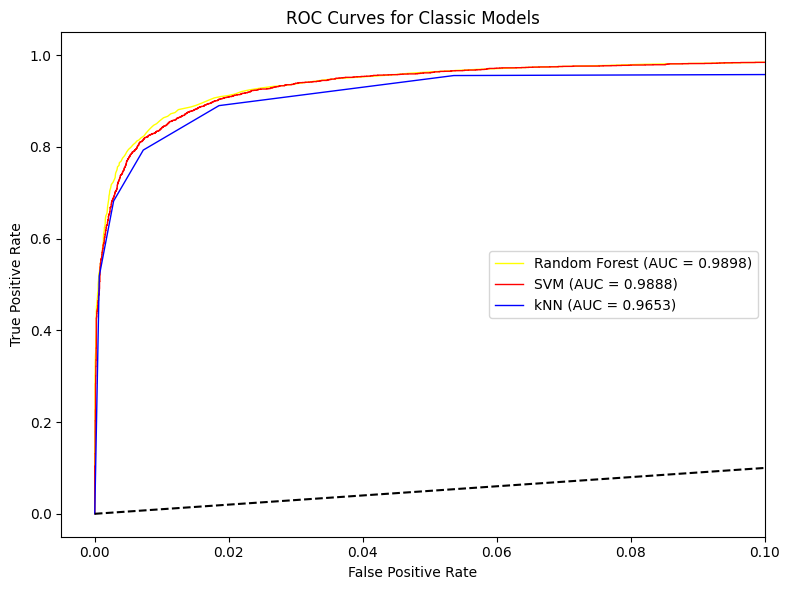

In [45]:
# Select the best model based on the ROC-AUC score
best_model_name = classic_models_results_df["roc_auc"].idxmax()
best_model = models[best_model_name]

print("\nBest classical model with the highest ROC-AUC score:", best_model_name)

plt.figure(figsize=(8, 6))
colors = {
    "Random Forest": "yellow",
    "SVM": "red",
    "kNN": "blue"
}

# Prepare a matrix with the class names
classes = np.unique(y_train)

# Creating a binary matrix of samples and classes
# Each column is 1 if the sample belongs to that class
y_test_matrix = np.zeros((len(y_test), len(classes)), dtype=int)
for j, c in enumerate(classes):
    y_test_matrix[:, j] = (y_test == c).astype(int)

# Plot an ROC curve for each classical model
for name, y_prob in probabilities.items():

    # Generate the false positive and true positive rates
    fpr, tpr, _ = roc_curve(y_test_matrix.ravel(), y_prob.ravel())

    # Get AUC from the results table
    auc_val = classic_models_results_df.loc[name, "roc_auc"]
    plt.plot(
            fpr,
            tpr,
            lw=1,
             color=colors[name],
             label=f"{name} (AUC = {auc_val:.4f})"
             )

# Baseline
plt.plot([0, 1], [0, 1], 'k--')
# Zoom in for visability
plt.xlim(-0.005, 0.10)
# Plot curves
plt.title("ROC Curves for Classic Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Deep Learning Model: Custom Convolutional Neural Network Built on a Pretrained ResNet50

In [151]:
# Preprocessing for ResNet50
# Note: The dataset was normalised to the 0 - 1 range for the classic model training
# however I should have assigned these values to be stored in a separate variable
# instead of overwriting the original pixel values
# Undo the normalisation because ResNet50 expects values between 0 and 255
X_train_res = preprocess_input((X_train * 255).astype("float32"))
X_val_res   = preprocess_input((X_val   * 255).astype("float32"))
X_test_res  = preprocess_input((X_test  * 255).astype("float32"))

# Load the pretrained ResNet50 convolutional base
base_model = ResNet50(
    input_shape=X_train_res.shape[1:], # The model input shape
    include_top=False,                 # Remove the original imagenet classifier
    weights="imagenet"                 # trained on the imagenet images
)

# Freeze all layers of ResNet50 so only the custom classifier trains
base_model.trainable = False

# Build the full custom CNN model
resnet_model = tf.keras.models.Sequential([
    base_model,                                         # Pretrained ResNet model
    layers.GlobalAveragePooling2D(),                    # Converts feature maps
    layers.Dense(256, activation='relu'),               # Custom fully connected layer
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')     # Output layer
])

# Compile the model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Learning rate to modulate how it changes over time
    loss="sparse_categorical_crossentropy",                 # Suitable for integer labels
    metrics=["accuracy"]
)

resnet_model.summary()

# Early stop monitors the validation loss and stops training when performance no longer improves
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Training of the model
history_res = resnet_model.fit(
    X_train_res, y_train,
    validation_data=(X_val_res, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set
test_loss_res, test_acc_res = resnet_model.evaluate(X_test_res, y_test, verbose=0)
print(f"\nResNet50 Test Accuracy: {test_acc_res * 100:.2f}%")
print(f"ResNet50 Test Loss: {test_loss_res:.4f}")


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,116,111 (92.00 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 166s 356ms/step - accuracy: 0.7653 - loss: 0.7246 - val_accuracy: 0.8963 - val_loss: 0.3073
Epoch 2/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 159s 352ms/step - accuracy: 0.8811 - loss: 0.3538 - val_accuracy: 0.9234 - val_loss: 0.2287
Epoch 3/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 157s 347ms/step - accuracy: 0.9090 - loss: 0.2724 - val_accuracy: 0.9251 - val_loss: 0.2088
Epoch 4/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 155s 343ms/step - accuracy: 0.9172 - loss: 0.2346 - val_accuracy: 0.9289 - val_loss: 0.2135
Epoch 5/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 156s 346ms/step - accuracy: 0.9271 - loss: 0.2080 - val_accuracy: 0.9373 - val_loss: 0.1864
Epoch 6/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 157s 346ms/step - accuracy: 0.9367 - loss: 0.1844 - val_accuracy: 0.9419 - val_loss: 0.1779
Epoch 7/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 155s 344ms/step - accuracy: 0.9412 - loss: 0.1650 - val_accuracy: 0.9435 - val_loss: 0.1644
Epoch 8/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 155s 343ms/step - accuracy: 0.9457 -

# Deep Learning Model Evaluation
- precision
- recall
- F1 score
- accuracy

97/97 ━━━━━━━━━━━━━━━━━━━━ 34s 333ms/step


#### Custom CNN with ResNet50 Results

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       149
           1       0.99      1.00      0.99       221
           2       0.99      0.97      0.98       150
           3       0.90      0.95      0.93       150
           4       1.00      0.78      0.88        23
           5       0.97      0.98      0.98       319
           6       0.89      0.83      0.86       150
           7       0.94      0.91      0.93       287
           8       0.94      0.94      0.94       143
           9       0.98      0.94      0.96       266
          10       0.92      0.94      0.93       252
          11       0.83      0.94      0.88       210
          12       0.99      0.99      0.99       482
          13       0.98      0.95      0.96        56
          14       0.99      0.97      0.98       238

    accuracy                           0.95      3096
   macro avg       0.95      0.94      0.94      3096
weighted avg       0.95   

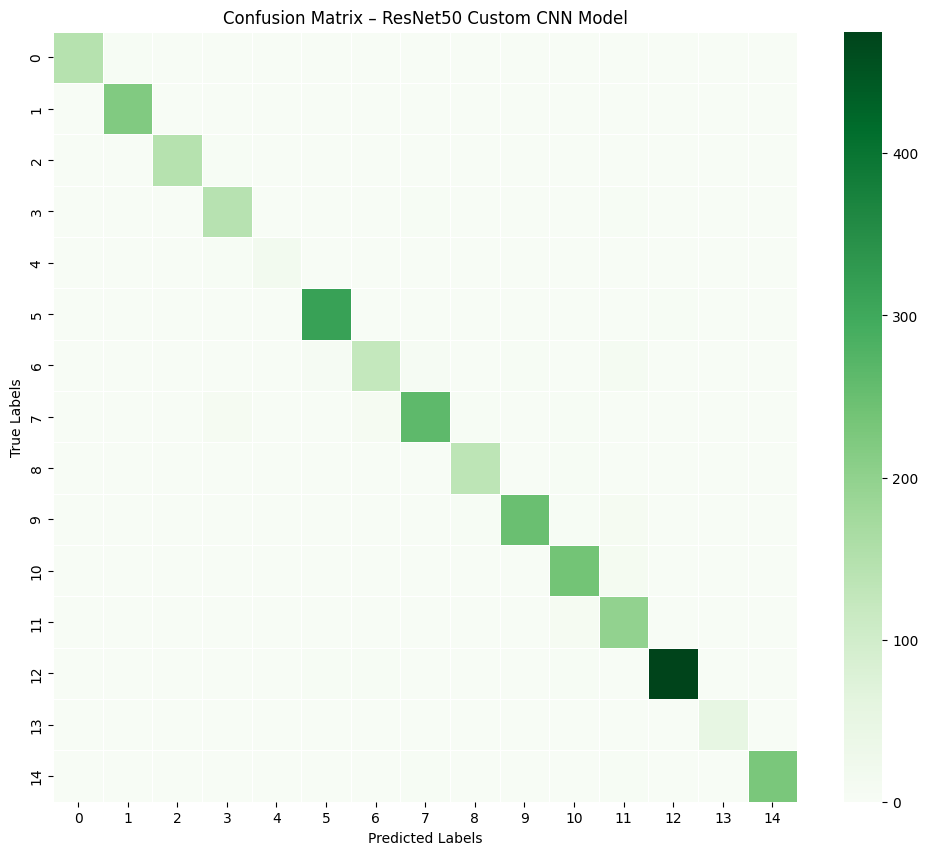

In [152]:
# Predict class probabilities on the test set
y_pred_proba = resnet_model.predict(X_test_res)

# Convert probabilities into predicted class labels
y_pred = np.argmax(y_pred_proba, axis=1)

display(Markdown("#### Custom CNN with ResNet50 Results"))
# Display an evaluation table to display metrics
print(classification_report(y_test, y_pred))

# Confusion matrix to visualise how many predictions were correct/incorrect per class
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Greens", linewidths=0.5)
plt.title("Confusion Matrix – ResNet50 Custom CNN Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Deep Learning Model Evaluation
- loss curve
- accuracy curve

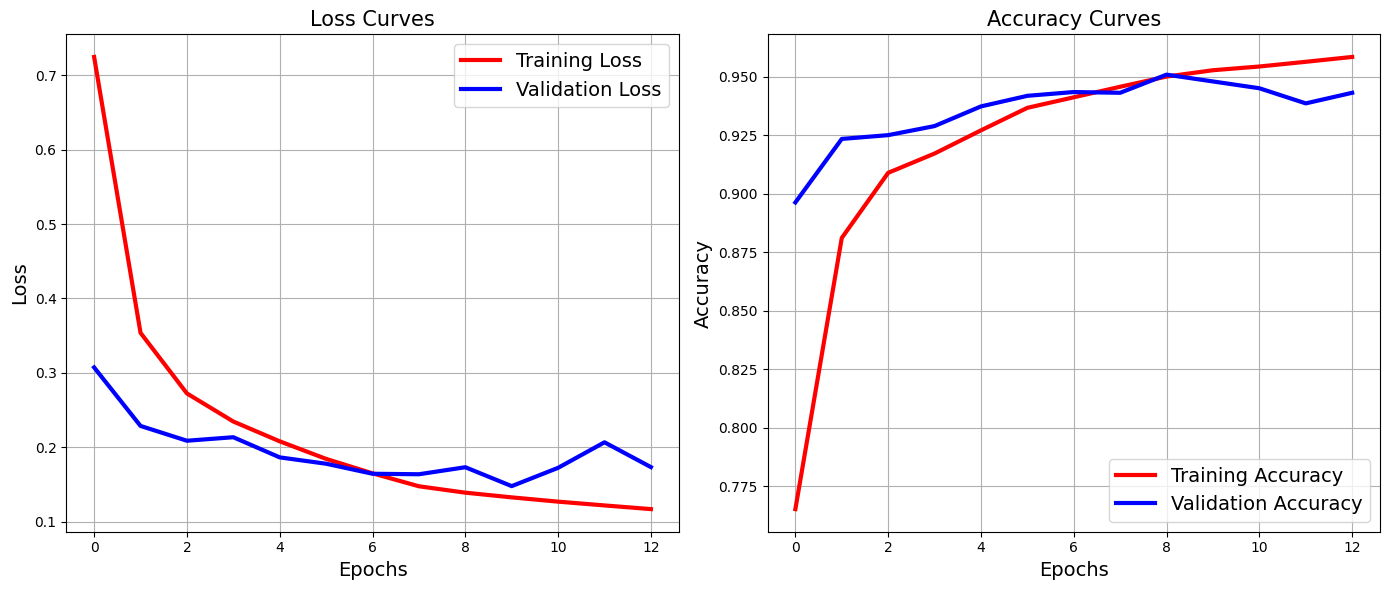

In [153]:
plt.figure(figsize=(14,6))

# Loss subplot
plt.subplot(1,2,1)
plt.plot(history_res.history["loss"], "r", linewidth=3.0)
plt.plot(history_res.history["val_loss"], "b", linewidth=3.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Loss Curves", fontsize=15)
plt.grid(True)

# Accuracy subplot
plt.subplot(1,2,2)
plt.plot(history_res.history["accuracy"], "r", linewidth=3.0)
plt.plot(history_res.history["val_accuracy"], "b", linewidth=3.0)
plt.legend(["Training Accuracy", "Validation Accuracy"], fontsize=14)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy Curves", fontsize=15)
plt.grid(True)

plt.tight_layout()
plt.show()

# Comparison Between Classic Machine Learning Models vs CNN


ResNet50 Accuracy:			 95.32%
ResNet50 ROC-AUC:			 0.9983


,accuracy,precision,recall,f1,roc_auc
Model,,,,,
Random Forest,0.864018,0.871656,0.812893,0.824681,0.989782
SVM,0.842700,0.835025,0.824009,0.827191,0.988840
kNN,0.836886,0.819213,0.806977,0.808386,0.965334
ResNet50,0.953165,0.953619,0.938283,0.944593,0.998341


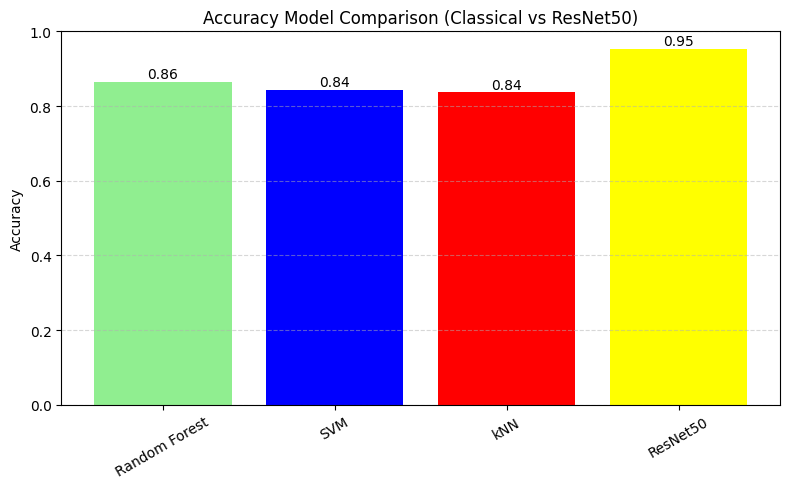

In [154]:
# Resnet metrics on the same y_test
y_test_proba_resnet = y_pred_proba   # probabilities from resnet
y_test_pred_resnet = y_pred          # predicted labels from resnet

# Accuracy
resnet_acc = accuracy_score(y_test, y_test_pred_resnet)

# For ROC-AUC we use the same style as classical models
resnet_roc = roc_auc_score(
    y_test,
    y_test_proba_resnet,
    multi_class="ovr",
    average="macro"
)

resnet_prec, resnet_rec, resnet_f1, _ = precision_recall_fscore_support(
    y_test,
    y_pred,
    average="macro"
)

print(f"ResNet50 Accuracy:\t\t\t {resnet_acc * 100:.2f}%")
print(f"ResNet50 ROC-AUC:\t\t\t {resnet_roc:.4f}")

# Add resnet results to the results table
classic_models_results_df.loc["ResNet50"] = {
    "accuracy": resnet_acc,
    "precision": resnet_prec,
    "recall": resnet_rec,
    "f1": resnet_f1,
    "roc_auc": resnet_roc
}

# Display table of comparison results
display(classic_models_results_df)


# Get model names and metrics from the table
model_names = classic_models_results_df.index.tolist()
accuracies = classic_models_results_df["accuracy"].values

plt.figure(figsize=(8, 5))

x = np.arange(len(model_names))

# Bar chart
plt.bar(x, accuracies, color=["lightgreen","blue","red","yellow"])
plt.xticks(x, model_names, rotation=30)
plt.ylabel("Accuracy")
plt.title("Accuracy Model Comparison (Classical vs ResNet50)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add value labels on top of bars so it's clearer to see
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.show()

# Model Explainability
- Grad-CAM: useful to highlight which parts of the image the model focused on the most when making its prediction


In [ ]:
# Build Grad-CAM

# Select an image index as an example to dispay
idx = 105

# Get the inner resnet layer and last conv layer
base_model = resnet_model.get_layer("resnet50")
last_conv_layer = base_model.get_layer("conv5_block3_out")

# Build a model that takes the original input and outputs the activations from the last conv layer
conv_model = tf.keras.Model(
    inputs=base_model.input,
    outputs=last_conv_layer.output
)

# Build the classifier head
# This model takes the output of the last conv layer and applies it to the remaining layers of the full model to generate the final predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input

take_layers = False
for layer in resnet_model.layers:
    # Skip layers until we reach the end of the resnet backbone
    if layer.name == "resnet50":
        take_layers = True
        continue
    if take_layers:
        x = layer(x)

classifier_model = tf.keras.Model(classifier_input, x)

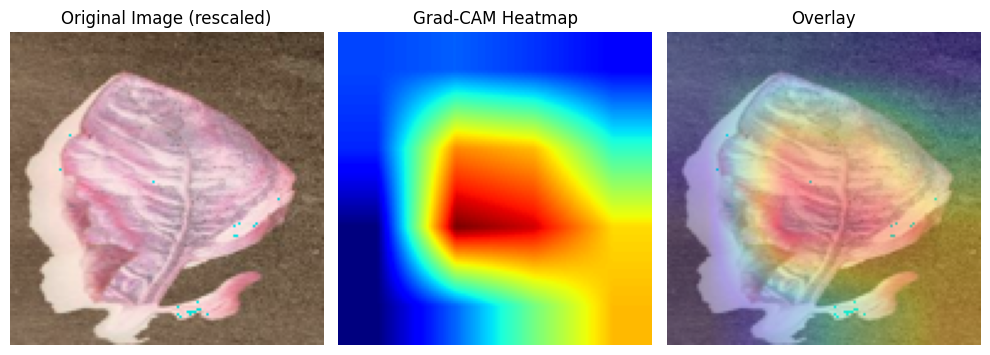

In [140]:
# Select the test image and prepare a 4D batch for the model
img_batch = X_test_res[idx:idx+1]


with tf.GradientTape() as tape:
    conv_output = conv_model(img_batch)
    tape.watch(conv_output)

    preds = classifier_model(conv_output)
    class_idx = tf.argmax(preds[0])
    class_score = preds[:, class_idx]

# Compute the gradients of the class score
grads = tape.gradient(class_score, conv_output)

# Importance of each feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weight feature maps by importance to form the Grad-CAM heatmap
conv_output = conv_output[0]
heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1)

heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap) + 1e-8
heatmap = heatmap.numpy()

# img_batch shape
img = img_batch[0]
h, w = img.shape[:2]

# Resize heatmap
heatmap_resized = tf.image.resize(
    heatmap[..., np.newaxis],
    (h, w)
).numpy().squeeze()

# Normalise image to [0, 1] just for plotting
img_disp = img.copy()
img_disp = img_disp - img_disp.min()
img_disp = img_disp / (img_disp.max() + 1e-8)

# Display original image, heatmap, and overlay
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_disp)
plt.title("Original Image (rescaled)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_disp)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.3)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

# Summary
#### Preprocessing
The preprocessing was one of the most time-consuming stages of this task because the data was split into multiple folders and I had to manually loop through each directory, load every image, convert it into an array, and correctly assign its label based on the folder name. Each image was then resized and normalised, augmentation techniques like flipping and rotation were applied to help improve the model's performance. Thorough validation checks needed to be performed to ensure that the images were loading correctly and the actions performing as expected such as normalisation of the pixels and image resizing.
#### Classical Machine Learning Models
Three different classical machine learning models such as k-NN, SVM and Random Forest were applied to the dataset and their performance was analysed using ROC-AUC scores, F1 scores, precision, recall, and accuracy metrics. The models were fed data from feature vectors extracted though colour histograms and Gabor filters. The colour histogram helped capture RGB value distribution whereas the Gabor filter was useful to detect texture which is useful to identify which leaves may be diseased.
#### Deep Learning Models
To achieve higher classification accuracy, two deep learning approached were implemented, a custom Convolutional Neural Network (CNN) and a deep learning model based on ResNet50. The custom CNN was implemented on top of the ResNet50-based model which was previously trained on the larger scale ImageNet dataset to perform fine-tuning. This allowed it to transfer its learned feature representations, such as texture detection, to the leaf classification task.The learning curve shows that both training and validation loss decreased rapidly within the first few epoch, however then there was a slight divergence between training and validation loss which suggests slight overfitting and learnt the training data too well and didn't generalise to new data well. 

#### Classic Models vs CNN Comparison
The classic machine learning models (k-NN, SVM, and Random Forest) performed reasonably well when trained on features extracted from the colour histograms and Gabor filters. However, the custom CNN paired with the ResNet50 model performed very well in comparison reaching up to scores of 95% accuracy. The results highlighted the limitation of classical machine learning models and the potential of CNNs as further enhancing could likely produce a higher accuracy result.
#### Explainability
Grad-CAM was used to provide visual explanations for how the deep learning model arrived at its predictions. By back-propagating gradients to the final convolutional layer of ResNet50, Grad-CAM produces a heatmap that highlights the specific regions of the leaf image that influenced the model’s decision. This helps verify that the model is focusing on meaningful areas such as, discoloured patches, texture irregularities, or visible disease spots, rather than irrelevant background pixels.

The heatmaps showed that the model consistently concentrated on the central regions of the leaf where disease symptoms were most prominent. This adds transparency to the deep learning approach and increases confidence that the model’s high accuracy is based on relevant visual features rather than noise. Grad-CAM therefore played an important role in validating the behaviour of the CNN and ensuring its predictions are trustworthy.
